# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [1]:
import pandas as pd
import sqlite3
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


/Users/a19028558/Desktop/transfer_accounts/akovyaz/learning_myself/env_school/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [2]:
df = pd.read_csv("../data/checker_submits.csv")
df.timestamp = df.timestamp.apply(lambda x: pd.Timestamp(x))

In [3]:
df['hour'] = df.timestamp.dt.hour
df['dayofweek'] = df.timestamp.dt.weekday

In [4]:
df.columns

Index(['uid', 'labname', 'numTrials', 'timestamp', 'hour', 'dayofweek'], dtype='object')

In [5]:
df.drop(inplace=True, columns=['timestamp'])

In [6]:
X = df.drop(columns=['dayofweek'])
y = df.dayofweek

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1686 entries, 0 to 1685
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   uid        1686 non-null   object
 1   labname    1686 non-null   object
 2   numTrials  1686 non-null   int64 
 3   hour       1686 non-null   int64 
 4   dayofweek  1686 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 66.0+ KB


In [8]:
encoder = OneHotEncoder()
scaler = StandardScaler()

In [9]:
X_cat = encoder.fit_transform(X[['uid', 'labname']])

In [10]:
X_real = scaler.fit_transform(X.drop(columns=['uid', 'labname']))

In [11]:
X = np.hstack([X_cat.toarray(), X_real])

In [12]:
pd.DataFrame(X).to_csv('../data/dayofweek.csv', index=False, header=False)

In [13]:
accuracy_score(y, np.repeat(y.mode()[0], len(X)))

0.23487544483985764

## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [14]:
log_reg = LogisticRegression(random_state=21, fit_intercept=True, penalty='none', solver='sag', max_iter=2000)
log_reg.fit(X, y)

LogisticRegression(max_iter=2000, penalty='none', random_state=21, solver='sag')

In [15]:
prev = log_reg.predict(X)
accuracy_score(y, prev)

0.66073546856465

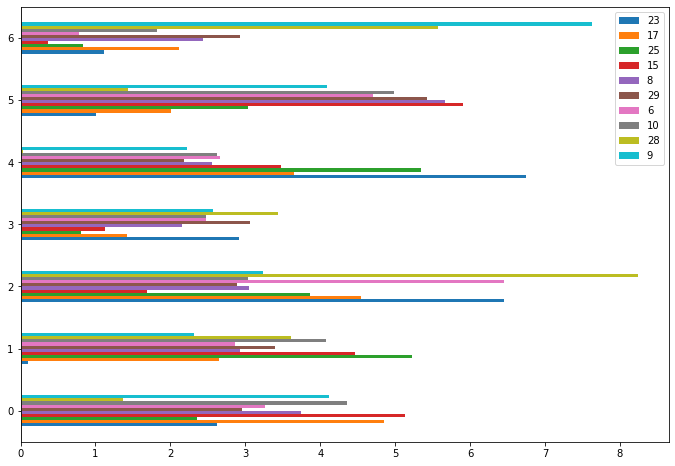

In [16]:
abs(pd.DataFrame(log_reg.coef_))[abs(pd.DataFrame(log_reg.coef_)).sum(axis=0).argsort()[-10:]].plot(kind='barh', figsize=(15, 8))
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [17]:
svc = SVC(random_state=21, probability=True, kernel='linear', C=10)
svc.fit(X, y)

SVC(C=10, kernel='linear', probability=True, random_state=21)

In [18]:
prev = svc.predict(X)
accuracy_score(y, prev)

0.7740213523131673

/Users/a19028558/Desktop/transfer_accounts/akovyaz/learning_myself/env_school/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


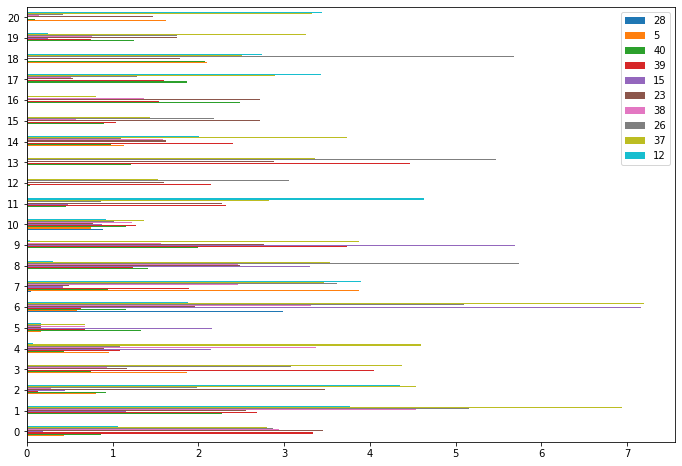

In [19]:
abs(pd.DataFrame(svc.coef_))[abs(pd.DataFrame(OneVsRestClassifier(svc).fit(X, y).coef_)).sum(axis=0).argsort()[-10:]].plot(kind='barh', figsize=(15, 8))
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [20]:
tree = DecisionTreeClassifier(random_state=21, max_depth=5)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=5, random_state=21)

In [21]:
prev = tree.predict(X)
accuracy_score(y, prev)

0.6109134045077106

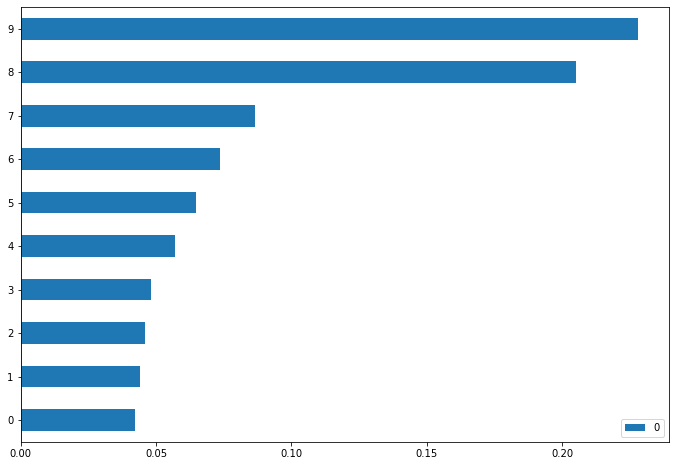

In [22]:
pd.DataFrame(np.sort(tree.feature_importances_)[-10:]).plot(kind='barh', figsize=(15, 8))
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [23]:
forest = RandomForestClassifier(n_estimators=50, max_depth = 25, random_state=21)
forest.fit(X, y)

RandomForestClassifier(max_depth=25, n_estimators=50, random_state=21)

In [24]:
prev = forest.predict(X)
accuracy_score(y, prev)

0.9994068801897983

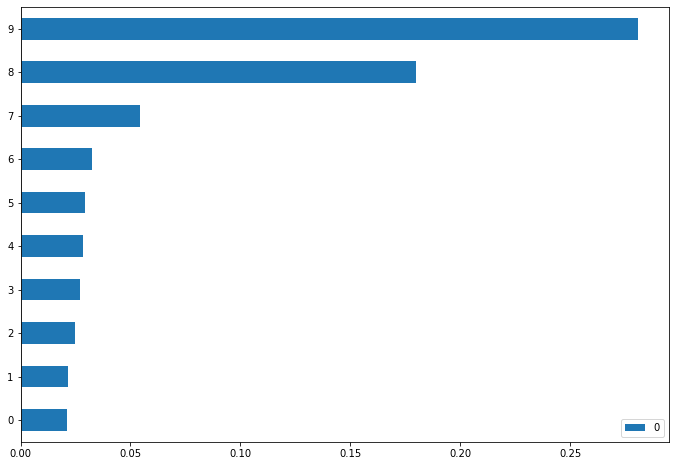

In [25]:
pd.DataFrame(np.sort(forest.feature_importances_)[-10:]).plot(kind='barh', figsize=(15, 8))
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)